<a href="https://colab.research.google.com/github/franklinhamer2727/Apuntes-de-IA/blob/main/AnalisisBBVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost
import math as mt
import warnings
matplotlib.style.use('bmh')
%matplotlib inline

warnings.filterwarnings('ignore')


In [41]:
!unzip bbvadatachallenge-recomendador.zip -d /content/data
!ls


Archive:  bbvadatachallenge-recomendador.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of bbvadatachallenge-recomendador.zip or
        bbvadatachallenge-recomendador.zip.zip, and cannot find bbvadatachallenge-recomendador.zip.ZIP, period.
bbvadatachallenge-recomendador.zip  data  result  sample_data


In [37]:
#dataset de entrenamiento a nivel de transacciones
TrainTxt = pd.read_csv('./data/01dataBaseTrainTrxRec.csv')
TrainTxt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16125 entries, 0 to 16124
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fechaOper          16125 non-null  object 
 1   codCliente         16125 non-null  int64  
 2   codGiro            15153 non-null  float64
 3   codEstab           16125 non-null  int64  
 4   flagLimaProvEstab  16125 non-null  int64  
 5   ubigeoEstab        15153 non-null  float64
 6   ctdTrx             16125 non-null  int64  
 7   ratingMonto        16124 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 1007.9+ KB


In [38]:
TrainTxt

,fechaOper,codCliente,codGiro,codEstab,flagLimaProvEstab,ubigeoEstab,ctdTrx,ratingMonto
0,2017-01-29 00:00:00,7649,138.0,43629,1,176.0,1,0.014072
1,2016-12-01 00:00:00,24604,75.0,4326,0,81.0,1,0.001667
2,2017-06-01 00:00:00,15289,75.0,4326,0,81.0,1,0.000127
3,2017-09-22 00:00:00,5190,110.0,59776,1,156.0,1,0.001167
4,2017-05-05 00:00:00,16635,75.0,31043,0,81.0,1,0.047386
...,...,...,...,...,...,...,...,...
16120,2017-04-18 00:00:00,9086,NaN,54931,0,NaN,1,0.001364
16121,2017-10-26 00:00:00,4502,75.0,4322,1,148.0,1,0.002344
16122,2017-09-26 00:00:00,25768,110.0,61458,1,403.0,1,0.004026
16123,2017-08-03 00:00:00,27022,75.0,4292,1,167.0,2,0.013468


In [39]:
#Eliminando columnas no relevantes
TrainTxt.drop(['fechaOper','ctdTrx'],axis=1, inplace=True)

In [40]:
#Ordenamiento por clientes y establecimeintos
TrainTxt.sort_values(by=['codCliente','codEstab']).head()

,codCliente,codGiro,codEstab,flagLimaProvEstab,ubigeoEstab,ratingMonto
10778,2,210.0,8273,1,148.0,0.013170
14222,4,75.0,4315,0,112.0,0.000772
7302,4,75.0,4328,0,112.0,0.004353
12235,4,110.0,76020,0,112.0,0.003300
12626,6,69.0,4216,1,143.0,0.002024


In [44]:
TrainPer = pd.read_csv('./data/02dataBasePerfilRec.csv')
TrainPer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14164 entries, 0 to 14163
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   codCliente           14164 non-null  int64  
 1   rangoEdad            14129 non-null  object 
 2   rangoIngreso         13572 non-null  object 
 3   flagGenero           14164 non-null  int64  
 4   flagLimaProvCliente  14164 non-null  int64  
 5   ubigeoCliente        14162 non-null  float64
 6   rangoCtdProdAct      14164 non-null  object 
 7   rangoCtdProdPas      14164 non-null  object 
 8   rangoCtdProdSeg      14164 non-null  object 
 9   flagBxi              14164 non-null  int64  
 10  saldoTcEntidad1      11082 non-null  object 
 11  saldoTcEntidad2      11082 non-null  object 
 12  saldoTcEntidad3      11082 non-null  object 
 13  saldoTcEntidad4      11082 non-null  object 
dtypes: float64(1), int64(4), object(9)
memory usage: 1.5+ MB


In [45]:
TrainPer.sort_values(by=['codCliente']).head()

,codCliente,rangoEdad,rangoIngreso,flagGenero,flagLimaProvCliente,ubigeoCliente,rangoCtdProdAct,rangoCtdProdPas,rangoCtdProdSeg,flagBxi,saldoTcEntidad1,saldoTcEntidad2,saldoTcEntidad3,saldoTcEntidad4
1599,1,Rango6,Rango5,1,1,246.0,Rango1,Rango2,Rango1,1,Rango1,Rango1,Rango1,Rango1
700,3,Rango6,Rango5,0,1,253.0,Rango1,Rango2,Rango2,0,Rango6,Rango2,Rango1,Rango2
1812,6,Rango6,Rango4,0,1,248.0,Rango1,Rango2,Rango2,1,Rango2,Rango1,Rango1,Rango1
5570,10,NaN,Rango3,1,1,270.0,Rango1,Rango1,Rango1,0,NaN,NaN,NaN,NaN
12136,11,Rango6,Rango1,1,1,262.0,Rango1,Rango1,Rango2,0,Rango5,Rango1,Rango1,Rango1


In [46]:
TrainTot= pd.merge(TrainTxt, TrainPer, on='codCliente')
TrainTot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7672 entries, 0 to 7671
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   codCliente           7672 non-null   int64  
 1   codGiro              7217 non-null   float64
 2   codEstab             7672 non-null   int64  
 3   flagLimaProvEstab    7672 non-null   int64  
 4   ubigeoEstab          7217 non-null   float64
 5   ratingMonto          7671 non-null   float64
 6   rangoEdad            7662 non-null   object 
 7   rangoIngreso         7384 non-null   object 
 8   flagGenero           7672 non-null   int64  
 9   flagLimaProvCliente  7672 non-null   int64  
 10  ubigeoCliente        7667 non-null   float64
 11  rangoCtdProdAct      7672 non-null   object 
 12  rangoCtdProdPas      7672 non-null   object 
 13  rangoCtdProdSeg      7672 non-null   object 
 14  flagBxi              7672 non-null   int64  
 15  saldoTcEntidad1      6424 non-null   o

In [47]:
#Ordenando por cliente y establecimientos
TrainTot.sort_values(by=['codCliente','codEstab']).head()

,codCliente,codGiro,codEstab,flagLimaProvEstab,ubigeoEstab,ratingMonto,rangoEdad,rangoIngreso,flagGenero,flagLimaProvCliente,ubigeoCliente,rangoCtdProdAct,rangoCtdProdPas,rangoCtdProdSeg,flagBxi,saldoTcEntidad1,saldoTcEntidad2,saldoTcEntidad3,saldoTcEntidad4
6900,6,69.0,4216,1,143.0,0.002024,Rango6,Rango4,0,1,248.0,Rango1,Rango2,Rango2,1,Rango2,Rango1,Rango1,Rango1
6901,6,69.0,4216,1,143.0,0.018645,Rango6,Rango4,0,1,248.0,Rango1,Rango2,Rango2,1,Rango2,Rango1,Rango1,Rango1
6609,10,114.0,126,1,175.0,0.003228,NaN,Rango3,1,1,270.0,Rango1,Rango1,Rango1,0,NaN,NaN,NaN,NaN
2820,11,75.0,831,1,157.0,0.002942,Rango6,Rango1,1,1,262.0,Rango1,Rango1,Rango2,0,Rango5,Rango1,Rango1,Rango1
6032,12,122.0,17061,1,175.0,0.001470,Rango6,Rango6,1,1,280.0,Rango1,Rango2,Rango1,1,Rango1,Rango1,Rango6,Rango2


#Analisis exploratorio

In [48]:
TrainTot['ratingMonto'].describe()

count    7671.000000
mean        0.013243
std         0.033657
min         0.000013
25%         0.001581
50%         0.004109
75%         0.011499
max         0.915942
Name: ratingMonto, dtype: float64

(-0.04578300029700978, 0.9617384589513414, -0.5, 0.5)

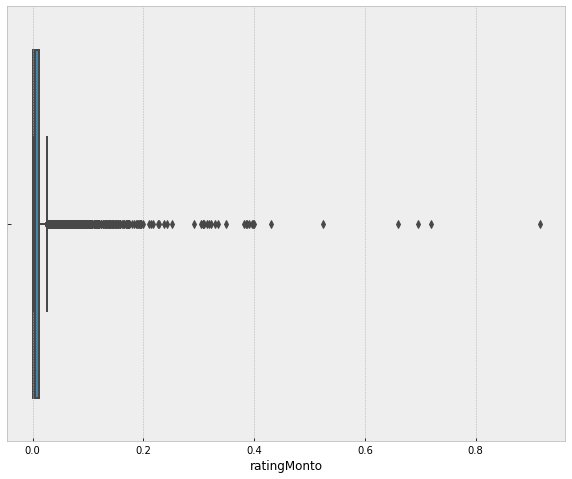

In [64]:
f, ax = plt.subplots(figsize=(10,8))
fig = sns.boxplot(x=TrainTot['ratingMonto']);
fig.axis(ymin=-0.5,ymax=0.5)

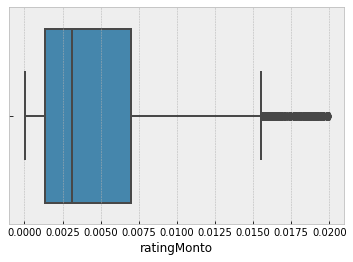

In [66]:
TrainTot1 = TrainTot[TrainTot['ratingMonto']<0.02]
sns.boxplot(x=TrainTot1['ratingMonto'])

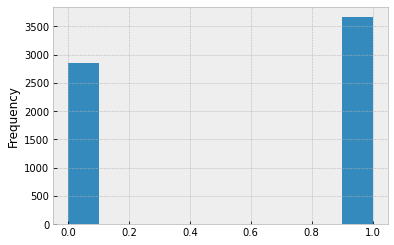

In [69]:
TrainTot1.flagGenero.plot.hist()

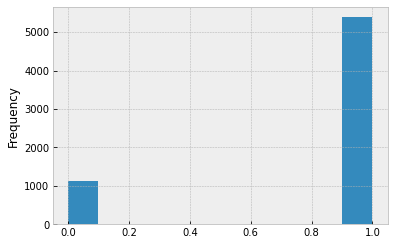

In [70]:
TrainTot1.flagLimaProvEstab.plot.hist();

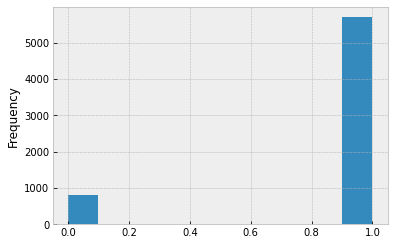

In [71]:
TrainTot1.flagLimaProvCliente.plot.hist();

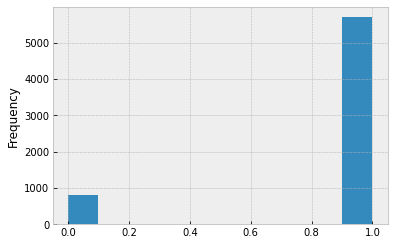

In [72]:
TrainTot1.flagBxi.plot.hist();

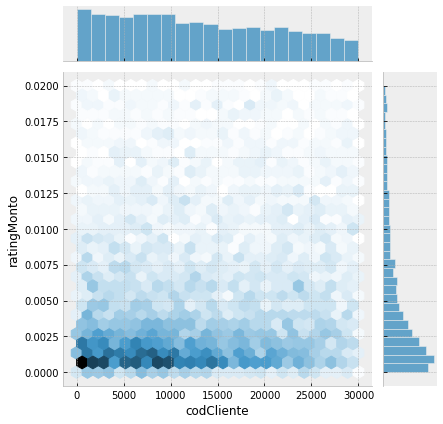

In [73]:
sns.jointplot(x='codCliente', y='ratingMonto', data=TrainTot1, kind="hex");

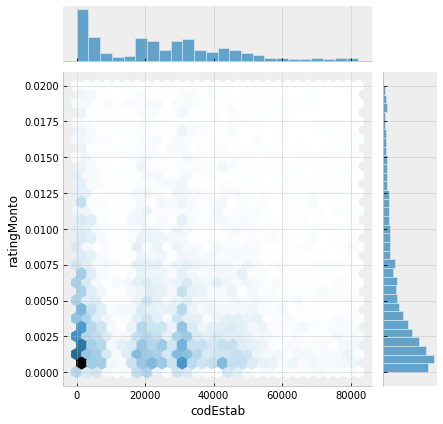

In [75]:
sns.jointplot(x='codEstab', y='ratingMonto', data=TrainTot1, kind="hex");

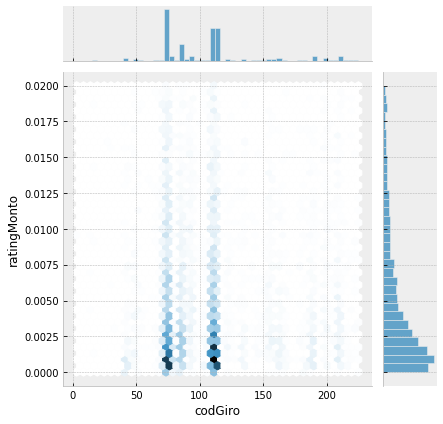

In [74]:
sns.jointplot(x='codGiro', y='ratingMonto', data=TrainTot1, kind="hex");

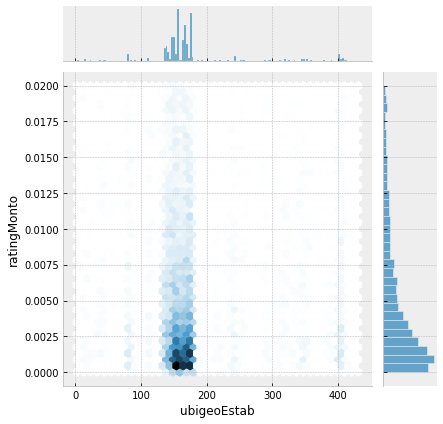

In [76]:
sns.jointplot(x='ubigeoEstab', y='ratingMonto', data=TrainTot1, kind="hex");

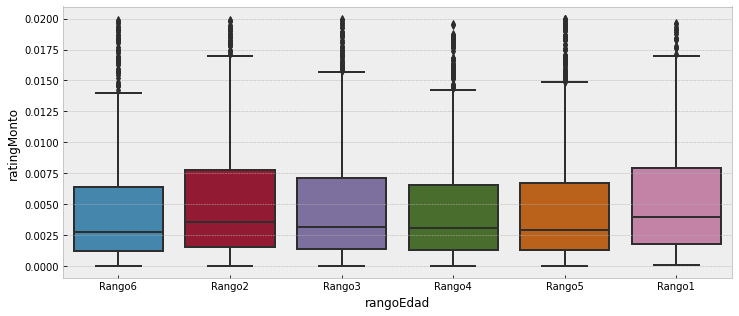

In [77]:
f, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(x='rangoEdad', y='ratingMonto', data=TrainTot1);

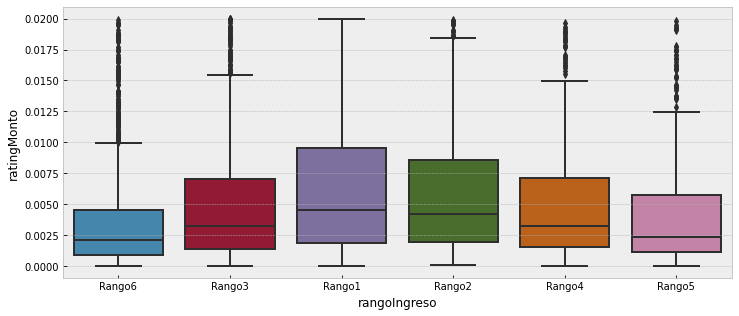

In [78]:
f, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(x='rangoIngreso', y='ratingMonto', data=TrainTot1);